# What happens in this notebook :-)

* We read in MC samples for background and different signal models. We also read in the actual data from the L3 detector.

* We train a BDT for a binary classification problem aiming to seperate signal from background.

* Different checks such as generalization of the BDT on the test sample as well as the confusion matrix are shown.

* We use the BDT response to place our cut, so we analyze efficiencies and purities for different cut positions.

* The BDT is saved in a pickel file.

### import packages

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

from sklearn.metrics import confusion_matrix
import itertools

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']

\begin{array}{|l||c|c|c|c|}
\hline
\textrm{sample name} & \textrm{type of data} & \textrm{real data} & \textrm{No. of events} & \sigma   [\textrm{pb}] \\ \hline
\textrm{higgs_qq} & q \bar{q} & - & 200000 & 102 \\ \hline
\textrm{higgs_ww} & W^+ W^- & - & 294500 & 16.5 \\ \hline
\textrm{higgs_zz} & ZZ & - & 196000 & 0.975 \\ \hline
\textrm{higgs_zee} & Z e^+ e^- & - & 29500 & 3.35 \\ \hline
\textrm{higgs_wen} & q \bar{q} e \nu_e & - & 81786 & 2.90 \\ \hline
\textrm{higgs_eeqq} & \textrm{two photon coll} & - & 5940000 & 15600 \\ \hline
\textrm{higgs_data} & \textrm{data} & x & - & - \\ \hline
\textrm{higgs_higgs_85} & \textrm{Higgs} (m_{H} = 85 \ \textrm{GeV}) & - & 3972 & 0.0940\\ \hline
\textrm{higgs_higgs_90} & \textrm{Higgs} (m_{H} = 90 \ \textrm{GeV}) & - & 3973 & 0.0667\\ \hline
\textrm{higgs_higgs_95} & \textrm{Higgs} (m_{H} = 95 \ \textrm{GeV}) & - & 3971 & 0.0333\\ \hline	
\end{array}

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [15]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame["class"] = 0

#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame["class"] = 1
    
#add column 'weight'=1 to data 
data["weight"] = 1



# Pick the Signal Model and produce data frames

In [16]:
signalModelindex = 0

df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
df_MC_mH85 = framesMC_HiggsModels[signalModelindex]
#merge bkg and sig MC
df_mH85 = pd.concat([df_MC_noHiggs,df_MC_mH85])

## Perform selection cut analysis

In [17]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']+['class','weight']
    return df[discriminating_vars]

In [18]:
# choose only those columns which have some kinematical meaning and thus can be used for training
df_MVA_mH85 = PickDiscVar_mH85(df=df_mH85)

In [19]:
print df_MVA_mH85.columns

print (len(df_MVA_mH85.columns)-2)

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'class', u'weight'],
      dtype='object')
33


In [20]:
# extract target values
# 0 <-> bkg
# 1 <-> sig
target = df_MVA_mH85['class']
del df_MVA_mH85['class']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_MVA_mH85, target, 
                                                    stratify=target, 
                                                    random_state=42,
                                                   train_size=0.65)
X_train_w = X_train['weight']
X_test_w = X_test['weight']


print('No of train events', len(y_train))
print('No of signal events',np.count_nonzero(y_train))
print('fraction of bkg in training set',1 - 1.*np.count_nonzero(y_train) / len(y_train))

print('-----------------------------')

print('No of test events',len(y_test))
print('No of signal events',np.count_nonzero(y_test))
print('fraction of bkg in test set',1 - 1.*np.count_nonzero(y_test) / len(y_test))


del X_train['weight']
del X_test['weight']

('No of train events', 49997)
('No of signal events', 2179)
('fraction of bkg in training set', 0.9564173850431026)
-----------------------------
('No of test events', 26922)
('No of signal events', 1174)
('fraction of bkg in test set', 0.9563925414159423)


# Initialize the Gradient Boosting Classifier

In [22]:
grbcl = GradientBoostingClassifier(max_depth=3,random_state=0,learning_rate=0.01,n_estimators=300)#,n_estimators=100,learning_rate=0.3)
grbcl.fit(X_train,y_train,sample_weight=X_train_w)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [23]:
print("Training set score: {:.3f}".format(grbcl.score(X_train, y_train,sample_weight=X_train_w)))
print("Test set score: {:.3f}".format(grbcl.score(X_test, y_test,sample_weight=X_test_w)))

Training set score: 0.983
Test set score: 0.983


[  1.11166186e-01   1.18437100e-01   5.87097088e-02   7.14872270e-02
   6.52091599e-02   8.28944793e-02   1.96883907e-03   3.13972646e-04
   4.69073081e-02   9.17991302e-02   2.04167427e-03   2.71110753e-01
   4.19200967e-02   5.12326360e-04   3.83603060e-03   2.47333553e-03
   1.24818509e-02   8.74442344e-03   5.52623005e-03   4.75585483e-06
   1.28070339e-03   0.00000000e+00   0.00000000e+00   2.13641543e-06
   1.39149495e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.32887099e-04   0.00000000e+00   5.38294040e-04   0.00000000e+00
   0.00000000e+00]
1.0


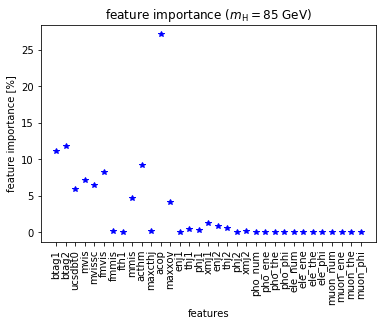

In [24]:
importance = grbcl.feature_importances_
feature = np.arange(len(X_train.columns))

print importance
print importance.sum()
fig, ax = plt.subplots()

plt.title(r"feature importance ($m_\mathrm{H} = 85$ GeV)")
plt.plot(feature,importance*100,'b*')
plt.xticks(feature)
ax.set_xticklabels(X_train.columns,rotation=90)
plt.xlabel('features')
plt.ylabel('feature importance [%]')
#plt.savefig("./plots/feature_importance")
plt.show()

26922
26922
[[25247   501]
 [  800   374]]


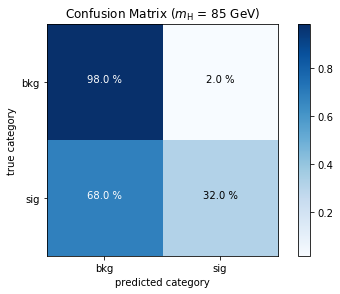

In [25]:
y_pred = grbcl.predict(X_test)

"""import cPickle
with open('BDT_85higgs.pkl', 'rb') as fid:
    gnb_loaded = cPickle.load(fid)
y_pred = gnb_loaded.predict(X_test)
"""
print(len(y_pred))
print len(y_test)

cm = confusion_matrix(y_pred,y_test)#,labels=["bkg","sig"])
cm = cm.T
print cm

cmap = plt.cm.Blues
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(2)
classes = ['bkg','sig']
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)



thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(np.round(cm[i, j]*100,0))+' %',
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title(r'Confusion Matrix ($m_\mathrm{H}$ = 85 GeV)')
plt.tight_layout()
plt.ylabel('true category')
plt.xlabel('predicted category')
#plt.savefig("./plots/confusion_matrix")

plt.show()

In [14]:
X_train_df = X_train.copy()
X_train_df['class'] = y_train

X_test_df = X_test.copy()
X_test_df['class'] = y_test

In [15]:
X_train_bkg = X_train_df[X_train_df['class']==0]
X_train_sig = X_train_df[X_train_df['class']==1]
del X_train_bkg['class']
del X_train_sig['class']

X_test_bkg = X_test_df[X_test_df['class']==0]
X_test_sig = X_test_df[X_test_df['class']==1]
del X_test_bkg['class']
del X_test_sig['class']



In [16]:
# evaluate test statistics on training set
a_bkg = grbcl.decision_function(X_train_bkg)
a_sig = grbcl.decision_function(X_train_sig)

# evaluate test statistics on test set
b_bkg = grbcl.decision_function(X_test_bkg)
b_sig = grbcl.decision_function(X_test_sig)



In [17]:
print len(a_bkg)
binning = np.linspace(min(b_bkg),max(a_sig),30)
binning = np.linspace(-8,5,30)


47818


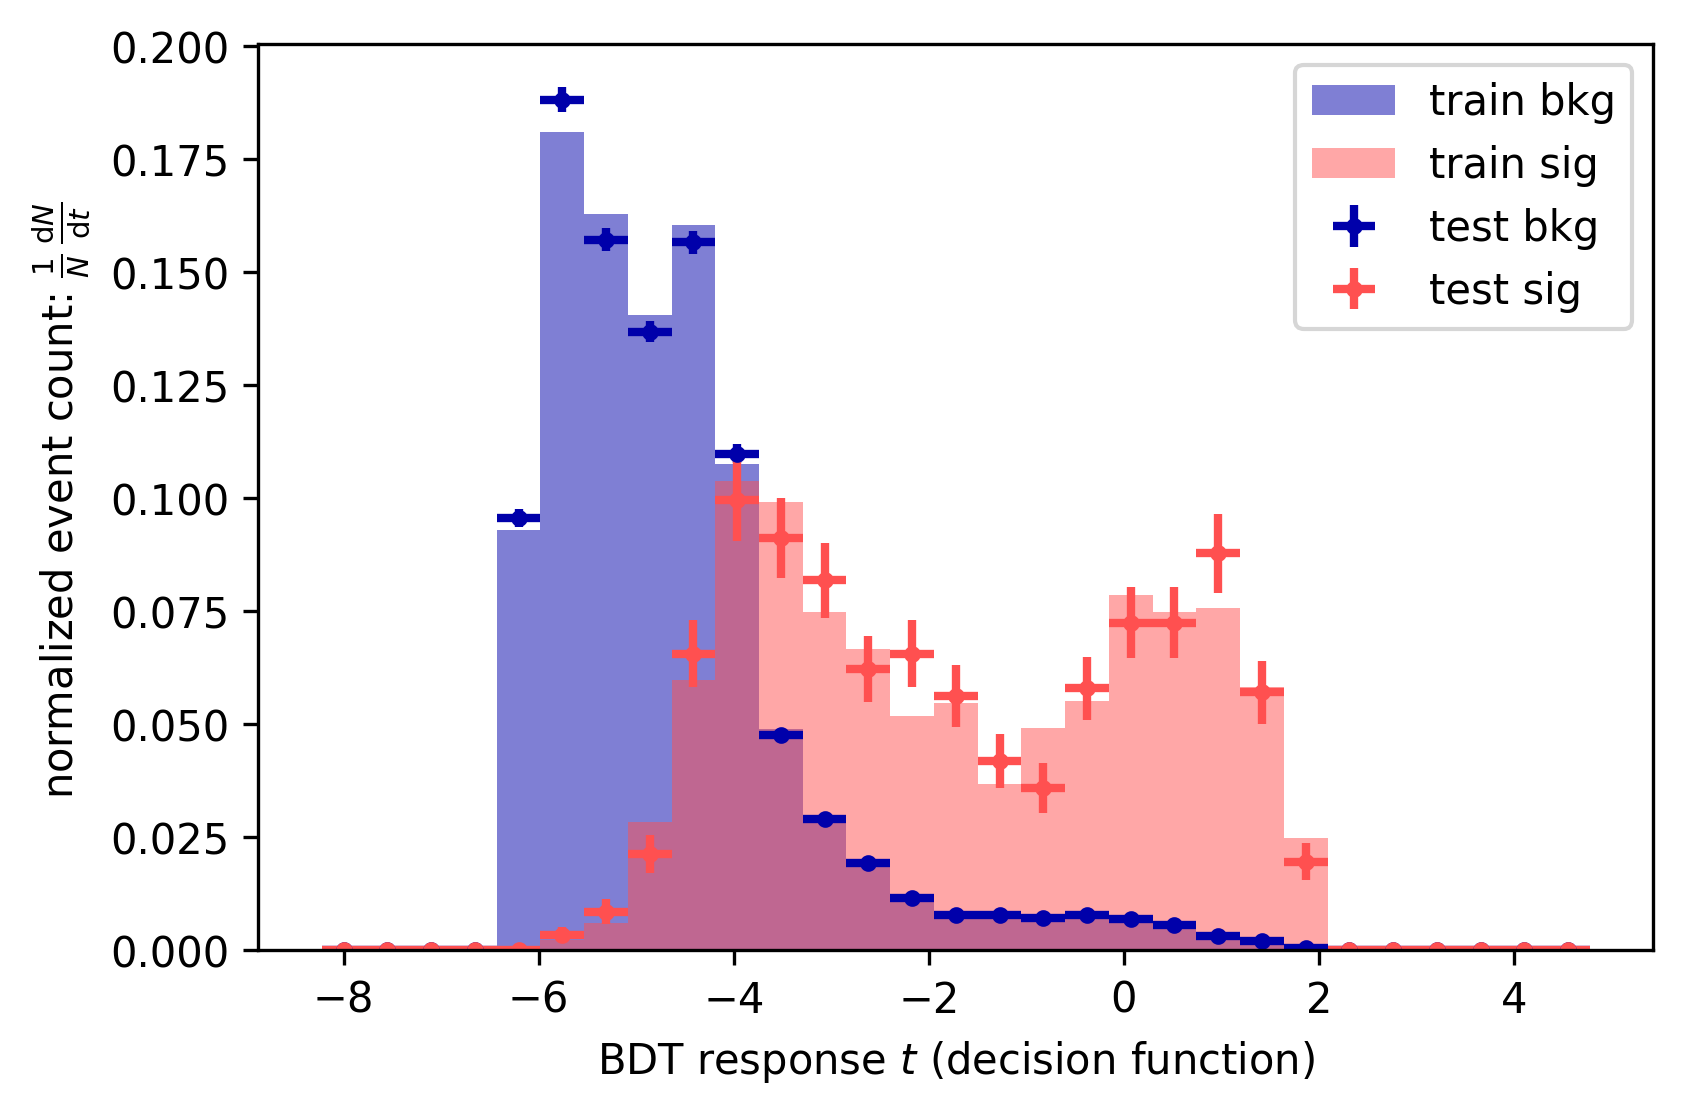

In [18]:
binw = binning[1] - binning[0]

N_a_bkg = np.histogram(a_bkg,bins=binning)[0]
norm_a_bkg = 1.*len(a_bkg)
N_a_sig = np.histogram(a_sig,bins=binning)[0]
norm_a_sig = 1.*len(a_sig)

plt.bar(left=binning[:-1],height=N_a_bkg/norm_a_bkg,width=binw,label='train bkg',alpha=0.5)
plt.bar(left=binning[:-1],height=N_a_sig/norm_a_sig,width=binw,label='train sig',alpha=0.5)


# test set part
N_bkg = np.histogram(b_bkg,bins=binning)[0]
norm_bkg = 1.*len(b_bkg)

N_sig = np.histogram(b_sig,bins=binning)[0]
norm_sig = 1.*len(b_sig)

plt.errorbar(binning[:-1],N_bkg/norm_bkg,xerr=binw/2.,label='test bkg',
            yerr=np.sqrt(N_bkg)/norm_bkg,fmt='.')
plt.errorbar(binning[:-1],N_sig/norm_sig,xerr=binw/2.,label='test sig',
            yerr=np.sqrt(N_sig)/norm_sig,fmt='.')
            
plt.ylabel(r'normalized event count: $\frac{1}{N} \, \frac{\mathrm{d} N}{\mathrm{d}t}$ ')
plt.xlabel(r'BDT response $t$ (decision function)')

plt.legend()
#plt.savefig("./plots/BDT_generalization_performance")

plt.show()

In [38]:
# calculate the number of events up to certain bin in t
# of the BDT response
sum_sig_cuts = []
sum_bkg_cuts = []

count = 0
for s in N_sig :
    count += s
    sum_sig_cuts.append(count)

count = 0
for s in N_bkg :
    count += s
    sum_bkg_cuts.append(count)


/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


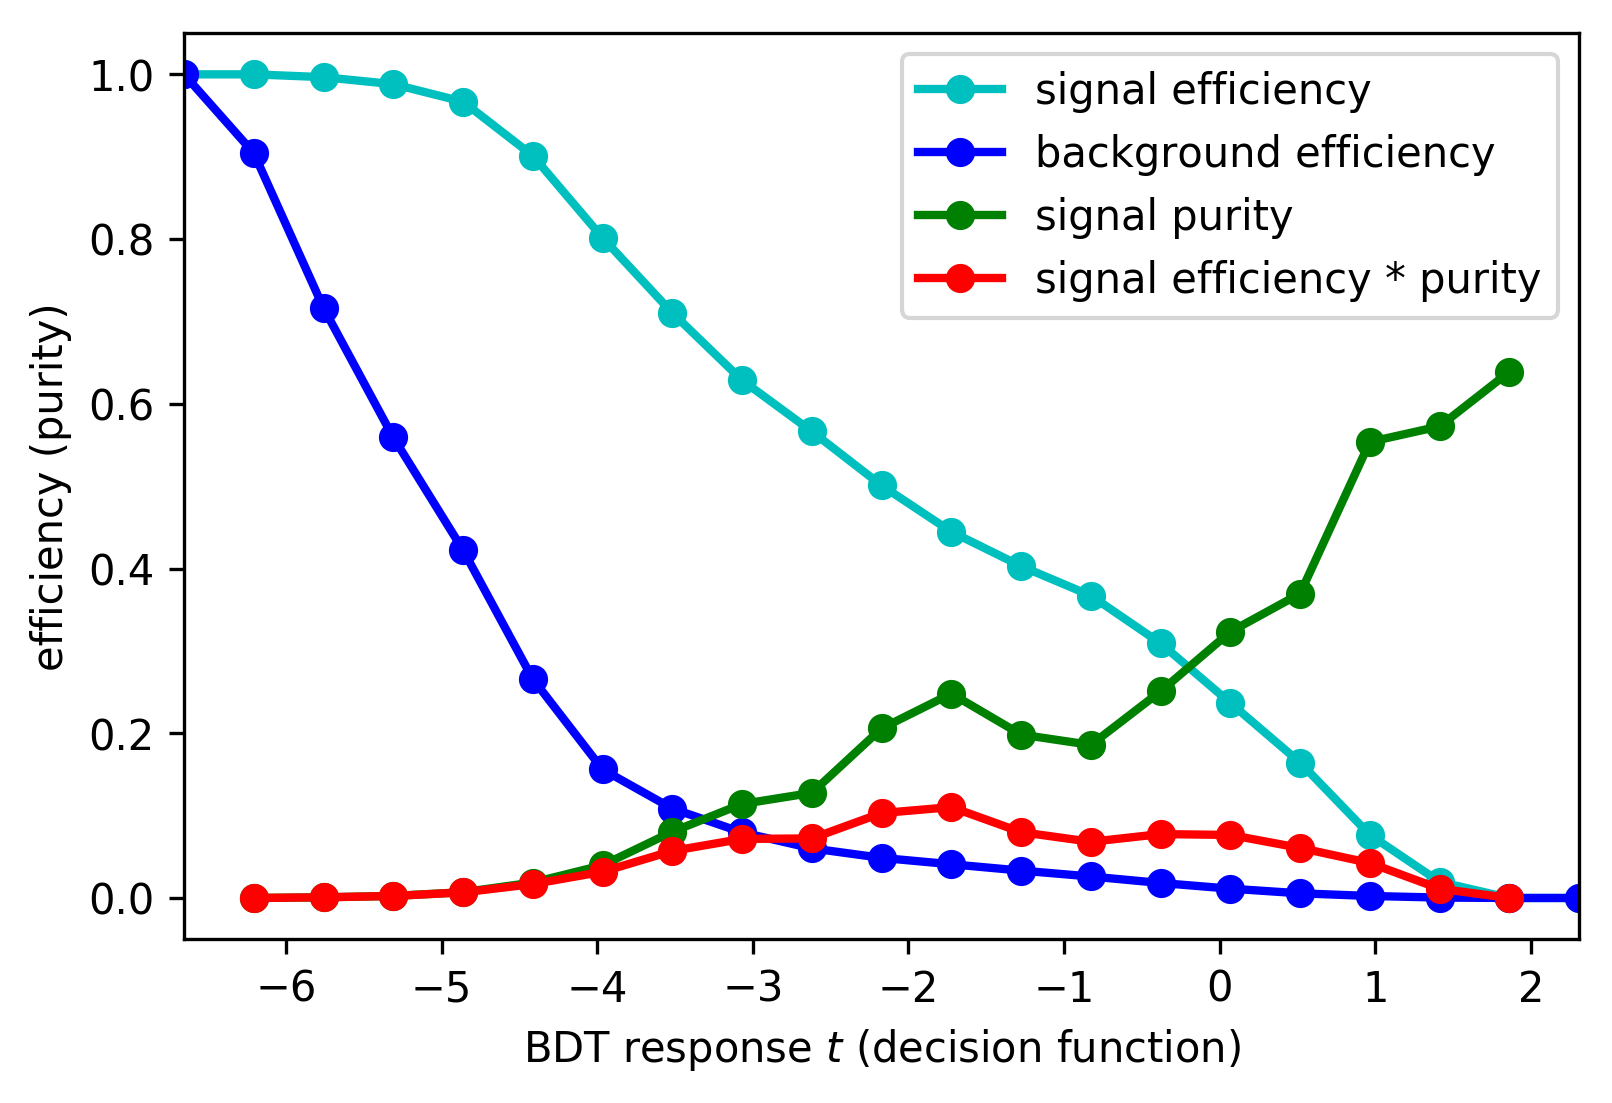

In [58]:
#plt.plot(binning[:-1],1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)),'mo-',label='significance')
#print binning[:-1][np.argmax(1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)))]
#plt.plot(np.sqrt(-2*(N_sig+N_bkg)*np.log(1+N_sig/N_bkg) + 2*N_sig),'ro--', label='lr significance')
#plt.hlines(3.,0,30)
#plt.vlines(14,0,7)
#plt.legend()
#plt.show()

#plt.vlines(14,0,1)
plt.plot(binning[:-1],1.-(np.array(sum_sig_cuts))/norm_sig,'co-',label='signal efficiency')
plt.plot(binning[:-1],1.-(np.array(sum_bkg_cuts))/norm_bkg,'bo-',label='background efficiency')
plt.plot(binning[:-1],1.*N_sig / (N_sig+N_bkg),'go-',label='signal purity')
plt.plot(binning[:-1],(1.*N_sig / (N_sig+N_bkg))*(1.-(np.array(sum_sig_cuts))/norm_sig),'ro-',label='signal efficiency * purity')
plt.legend()
plt.ylabel('efficiency (purity)')
plt.xlabel(r'BDT response $t$ (decision function)')
plt.xlim(-6.655,2.31)

#plt.savefig("./plots/BDT_eff_purity")
plt.show()

# Save Classifier

In [37]:
import cPickle
# save the classifier
with open('BDT_85higgs1.pkl', 'wb') as fid:
    cPickle.dump(grbcl, fid)    

# Visualize Decision Tree

In [11]:
from sklearn.tree import export_graphviz
import graphviz

In [12]:
tree = DecisionTreeClassifier(max_depth=2,random_state=0)
tree.fit(X_train,y_train,sample_weight=X_train_w.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [13]:
#save tree
export_graphviz(tree,out_file='tree.dot',class_names=['bkg','sig'],feature_names=X_train.columns,
               impurity=False,filled=True)



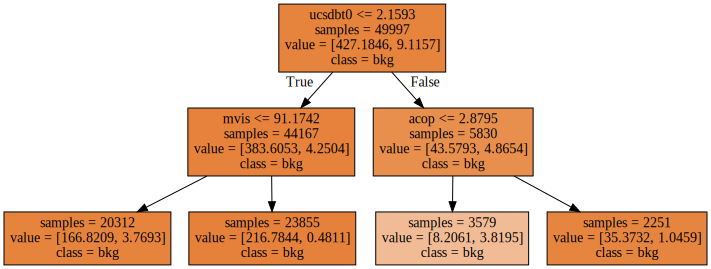

In [14]:
#open tree
with open('tree.dot') as f :
    dot_graph = f.read()
graphviz.Source(dot_graph)


in order to convert .dot to ps use:

dot -Tps tree.dot -o myTree.ps